In [3]:
import numpy as np

NNにおける単語処理方法（one-hotベクトル）

In [16]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W,  = self.params
        out = np.dot(x, W)
        self.x = x

        return out

    def backward(self, dout):
        W = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW # [0]はdWを格納する行（dbは[1]）

        return dx

In [17]:
c = np.array([1, 0, 0, 0, 0, 0, 0]) # 入力（コンテキスト）
W = np.random.randn(7,3) # 重み（分散表現）
layer = MatMul(W)
h= layer.forward(c) # 入力に対応する重み要素を抜き出す
print(h)

[-0.67012431 -0.61812647  1.48504869]


CBOW推論

In [78]:
# サンプル入力データ（前後のコンテキスト）
c0 = np.array([[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0]])
print(c0.shape)
print(c1.shape)

# 重みの初期化
W_in = np.random.randn(7, 3) # 全単語（７）の分散表現（３）を持つ
W_out = np.random.randn(3, 7) # 前後コンテキストの分散表現平均（３）からクラス分け（７）スコア出力計算に使う重み
print(W_in.shape)

# レイヤの生成
in_layer0 = MatMul(W_in) # ターゲット前の入力層
in_layer1 = MatMul(W_in) # ターゲット後の入力層
out_layer = MatMul(W_out) # 出力層

# 順伝播
h0 = in_layer0.forward(c0) # 入力（コンテキスト）と掛けてターゲット前の単語における分散表現取得
h1 = in_layer1.forward(c1) # 入力(コンテキスト)と掛けてターゲット後の単語における分散表現取得
h = 0.5 * (h0 + h1) # ターゲット前後の単語における分散表現の平均をとってまとめる（密なベクトル）
s = out_layer.forward(h) # スコア出力

print(s)



(2, 7)
(2, 7)
(7, 3)
[[ 0.64234954  1.4054378  -1.47185823 -1.9459261  -0.41461727 -0.02912885
   0.6770045 ]
 [ 1.10999031  0.39055732 -3.47384457 -2.99413625 -0.44300134 -0.57633968
   2.58994825]]


CBOWの学習

1. コープスから入力と正解ラベルを生成

In [79]:
# corpusからcontexts(入力)とtarget(正解ラベル)のリストを生成
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size] # targetはcorpusの両端からwindow_size分をのぞいたもの
    contexts = [] # 下記で取得

    # idx番目の前後コンテキストペア（ターゲットの数だけある＝コーパス内のidx番目のtarget）
    # 範囲に含まれないlen(corpus)番目からwindow_size分前までも範囲に含まれず、結果コーパス内のtargetのインデックス範囲が求まる
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # ターゲット前後のコンテキスト e.g. -1, 0, 1 (0：ターゲット, -1, 1：コンテキスト)
        for t in range(-window_size, window_size + 1):
            if t == 0: # ターゲットはスキップ
                continue
            cs.append(corpus[idx + t]) # corpus内ターゲットインデックスの前後コンテキストペアをcsリストに格納
        contexts.append(cs) # 現在のターゲット前後コンテキストペアcsをcontextsリストに格納

    return np.array(contexts), np.array(target)

In [80]:
import sys
sys.path.append(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master")
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(id_to_word)
print("corpus: ", corpus)

contexts, targets = create_contexts_target(corpus, window_size=1)
print(contexts)
print(targets)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
corpus:  [0 1 2 3 4 1 5 6]
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


2. cotexts(入力)とtarget(正解ラベル)をone-hot表現に変換

In [81]:
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換

    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0] # targetの要素数またはcontextsのコンテキストペア数（データ数）

    # target([1,2,3,4,1,5])だった場合
    if corpus.ndim == 1:
        # targetの要素数×語彙数の0配列作成
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        # idx番目のデータにおけるword_id番目を１にする
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1 # word_idと0配列の１にしたいインデックスが一致

    # contexts([[0,2],[1,3],[2,4],[3,1],[4,5],[1,6]])だった場合
    elif corpus.ndim == 2:
        # 各コンテキストの要素数（この場合は２）
        C = corpus.shape[1]
        # コンテキストペア数分における、コンテキスト数×語彙数の0配列作成
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        # idx_0番目のコンテキストペアであるwords_idsにおいて(e.g. 0番目のコンテキストペア: [0,2])
        for idx_0, word_ids in enumerate(corpus):
            # idx_1番目のword_id番目を１にする(e.g. 0番目のword_id: 0, 1番目のword_id: 2)
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1 # word_idと0配列の１にしたいインデックスが一致

    return one_hot

In [82]:
import sys
sys.path.append(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master")
from common.util import preprocess

text = 'You say goodbye and I say hello.'
# 文章をID番号に変換(コーパス)
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(id_to_word)
print("vocab_size: ", vocab_size)

# コーパスからコンテキスト（入力）とターゲット（正解ラベル）を生成
contexts, target = create_contexts_target(corpus, window_size=1)
print(target.shape)
print(contexts.shape)
print(target)
print(contexts)

# コンテキストとターゲットをhot-oneデータに変換（NNで使えるように）
vocab_size = len(id_to_word)
contexts_oh = convert_one_hot(contexts, vocab_size)
target_oh = convert_one_hot(target, vocab_size)
print(target_oh.shape)
print(contexts_oh.shape)
print(len(contexts_oh))
print(target_oh)
print(contexts_oh)



vocab_size:  7
(6,)
(6, 2)
[1 2 3 4 1 5]
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
(6, 7)
(6, 2, 7)
6
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


モデル実装

In [83]:
import sys
sys.path.append(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master")
from common.layers import SoftmaxWithLoss

class SimpleCBOW:
    #各レイヤのニューロンの数を設定
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        # 入力(6, 2, 7)と重み(7, 3)の積の結果：(6, 2, 3)
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 全語彙の分散表現
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 全ての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 分散表現(W_in)をメンバ変数に設定（あとで取り出すため）
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0]) # 入力（コンテキスト）と掛けてターゲット前の単語における分散表現取得
        h1 = self.in_layer1.forward(contexts[:, 1]) # 入力(コンテキスト)と掛けてターゲット後の単語における分散表現取得
        h = 0.5 * (h0 + h1) # ターゲット前後の単語における分散表現の平均をとってまとめる（密なベクトル）
        score = self.out_layer.forward(h) # スコア出力
        loss = self.loss_layer.forward(score, target)

        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)

        return None


学習コードの実装

In [84]:
# coding: utf-8
import sys

sys.path.append(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master")
import numpy
import time
import matplotlib.pyplot as plt
# import numpy as np
from common.util import clip_grads


class Trainer:
    # 一番最初に使用するモデルとパラメータ更新法を設定
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = [] # プロット描写用の記録
        self.eval_interval = None # 結果を表示する試行間隔（デフォルトでは設定なし：なしのままだと評価の出力されない）
        # self.current_epoch = 0
        self.current_iter = 0

    # 学習の設定（エポック数、バッチサイズ、勾配のノルム最大値（これより小さくする）、結果を表示する試行間隔）
    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=None):
        data_size = len(x)
        max_iters = data_size // batch_size # １エポック
        self.eval_interval = eval_interval # 結果を表示する試行間隔
        if eval_interval is not None and eval_interval == "epoch":
            eval_interval = max_iters
        model, optimizer = self.model, self.optimizer
        # 損失平均の途中経過出力のための記録用
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch): # 設定のエポック数まで試行
            # ランダムなインデックス要素を含むリストを生成しその並びにデータを置き換える
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters): # １エポックの間
                self.current_iter += 1 # 1エポック過ぎても全体の試行回数を記録する
                batch_x = x[iters * batch_size : (iters + 1) * batch_size] # e.g. x[0:30]
                batch_t = t[iters * batch_size : (iters + 1) * batch_size] # e.g. t[0:30]


                # 損失計算し、勾配を求め、パラメータを更新（学習）
                loss = model.forward(batch_x, batch_t)
                model.backward()
                # パラメータ更新時に共有された重みを1つに集約
                params, grads = remove_duplicate(model.params, model.grads)
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                # 後で損失平均を経過出力するために記録
                total_loss += loss
                loss_count += 1

                # 評価
                # eval_intervalが設定されかつのその試行回数に達した時
                if (eval_interval is not None) and ((self.current_iter) % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print(
                        "No. %d | epoch %d | iter %d | time %d[s] 0| loss %.2f"
                        % (len(self.loss_list) + 1, epoch + 1, self.current_iter, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss)) # プロット描写用に記録
                    total_loss, loss_count = 0, 0 # 次の損失平均記録のためリセット

            # self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list)) # 評価回数を横軸
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label="train") # その時の損失平均を縦軸
        plt.xlabel("iterations (x" + str(self.eval_interval) + ")")
        plt.ylabel("loss")
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype="i")
        batch_t = np.empty((batch_size, time_size), dtype="i")

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # バッチの各サンプルの読み込み開始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35, max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # パープレキシティの評価
                if (eval_interval is not None) and (iters + 1 % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print(
                        "| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f"
                        % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl)
                    )
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label="train")
        plt.xlabel("iterations (x" + str(self.eval_interval) + ")")
        plt.ylabel("perplexity")
        plt.show()


def remove_duplicate(params, grads):
    """
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    """
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif (
                    params[i].ndim == 2
                    and params[j].ndim == 2
                    and params[i].T.shape == params[j].shape
                    and np.all(params[i].T == params[j])
                ):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg:
                    break
            if find_flg:
                break

        if not find_flg:
            break

    return params, grads


No. 1 | epoch 3 | iter 5 | time 0[s] 0| loss 1.95
No. 2 | epoch 5 | iter 10 | time 0[s] 0| loss 1.95
No. 3 | epoch 8 | iter 15 | time 0[s] 0| loss 1.95
No. 4 | epoch 10 | iter 20 | time 0[s] 0| loss 1.95
No. 5 | epoch 13 | iter 25 | time 0[s] 0| loss 1.94
No. 6 | epoch 15 | iter 30 | time 0[s] 0| loss 1.94
No. 7 | epoch 18 | iter 35 | time 0[s] 0| loss 1.94
No. 8 | epoch 20 | iter 40 | time 0[s] 0| loss 1.94
No. 9 | epoch 23 | iter 45 | time 0[s] 0| loss 1.94
No. 10 | epoch 25 | iter 50 | time 0[s] 0| loss 1.94
No. 11 | epoch 28 | iter 55 | time 0[s] 0| loss 1.94
No. 12 | epoch 30 | iter 60 | time 0[s] 0| loss 1.94
No. 13 | epoch 33 | iter 65 | time 0[s] 0| loss 1.93
No. 14 | epoch 35 | iter 70 | time 0[s] 0| loss 1.93
No. 15 | epoch 38 | iter 75 | time 0[s] 0| loss 1.93
No. 16 | epoch 40 | iter 80 | time 0[s] 0| loss 1.92
No. 17 | epoch 43 | iter 85 | time 0[s] 0| loss 1.92
No. 18 | epoch 45 | iter 90 | time 0[s] 0| loss 1.91
No. 19 | epoch 48 | iter 95 | time 0[s] 0| loss 1.91
No. 20

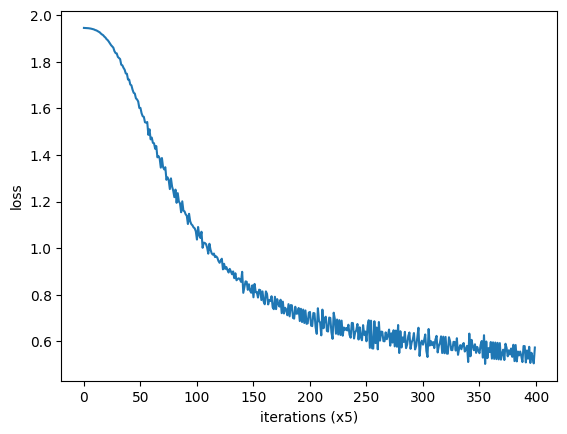

you [ 1.2721846 -1.0983977 -1.0142385  1.0427588 -1.3667469]
say [-0.06346767  1.209302    1.189429   -1.2450265   0.05651998]
goodbye [ 0.6203471  -0.8062882  -1.0034034   0.93815655 -0.44453883]
and [ 1.6233643  1.0135442  0.9874824 -1.0558016 -1.6445243]
i [ 0.63137835 -0.82768166 -1.0054835   0.9404938  -0.44391853]
hello [ 1.3002118 -1.0848393 -1.004984   1.0213854 -1.3508834]
. [-1.4137777  1.1019249  1.1240877 -1.1203241  1.4073246]


In [85]:
# coding: utf-8
import sys
sys.path.append(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-2-master")
# from common.trainer import Trainer
from common.optimizer import Adam
# from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=5)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])
